In [2]:
%run ./_setup.ipynb

# Compare TWDB with Radar Precipitation

## Read in radar data for each day of the storm

In [24]:
# create directory
os.makedirs(baser, exist_ok=True)

days = np.arange(25, 32)
for day in days:
    url = 'https://water.weather.gov/precip/downloads/2017/08/%i/nws_precip_1day_201708%i_conus.nc' % (day, day)
    fname = url.split('/')[-1]

    # this will download the file to the present file location
    !wget $url
    # move it to data directory
    %mv $fname $baser

--2019-10-05 11:09:57--  https://water.weather.gov/precip/downloads/2017/08/25/nws_precip_1day_20170825_conus.nc
Resolving water.weather.gov (water.weather.gov)... 104.73.167.46
Connecting to water.weather.gov (water.weather.gov)|104.73.167.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4051253 (3.9M) [application/x-netcdf]
Saving to: ‘nws_precip_1day_20170825_conus.nc’

nws_precip_1day_201 100%[===================>]   3.86M  6.99MB/s    in 0.6s    

2019-10-05 11:09:58 (6.99 MB/s) - ‘nws_precip_1day_20170825_conus.nc’ saved [4051253/4051253]

--2019-10-05 11:09:58--  https://water.weather.gov/precip/downloads/2017/08/26/nws_precip_1day_20170826_conus.nc
Resolving water.weather.gov (water.weather.gov)... 104.73.167.46
Connecting to water.weather.gov (water.weather.gov)|104.73.167.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3995246 (3.8M) [application/x-netcdf]
Saving to: ‘nws_precip_1day_20170826_conus.nc’

nws_precip_1day_

# Create Points for Gridded Rain Locations

In [5]:
Files = sorted(glob('%s/nws_precip_1day_201708??_conus.nc' % baser))
# File = Files[0]
# Read in rain data
# ds = xr.open_dataset(File)
ds = xr.open_mfdataset(Files, concat_dim='time', combine='nested')

# Set up x and y locations
X, Y = np.meshgrid(ds['x'].values, ds['y'].values)

# convert x and y locations to aea projection
rainaea = aea.transform_points(stereo, X, Y)
xrainaea = rainaea[:,:,0]; yrainaea = rainaea[:,:,1]
# combine together
xrainaea2 = np.hstack(((xrainaea[:,0]-abs(xrainaea[:,0]-xrainaea[:,1]))[:,np.newaxis],xrainaea))
yrainaea2 = np.vstack(((yrainaea[0,:]+abs(yrainaea[0,:]-yrainaea[1,:]))[np.newaxis,:],yrainaea))

# # calculate rain grid cell area
da = abs(xrainaea2[:,1:] - xrainaea2[:,:-1]) * abs(yrainaea2[1:,:] - yrainaea2[:-1,:])


# convert rain array to m^3
ds['observation'] = ds['observation']*2.54/100*da

ds

<xarray.Dataset>
Dimensions:                (time: 7, x: 1121, y: 881)
Coordinates:
  * x                      (x) float64 -1.903e+06 -1.898e+06 ... 3.432e+06
  * y                      (y) float64 -3.426e+06 -3.431e+06 ... -7.618e+06
  * time                   (time) datetime64[ns] 2017-08-25 ... 2017-08-31
Data variables:
    crs                    (time) int32 -2147483647 -2147483647 ... -2147483647
    observation            (time, y, x) float64 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
    normal                 (time, y, x) float32 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
    departure_from_normal  (time, y, x) float32 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
    percent_of_normal      (time, y, x) float32 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
Attributes:
    creation_time:  20190314T180953
    data_time:      20170825
    Conventions:    CF-1.6

## Find indices for rain by region

In [47]:
# radar = pd.read_csv('%s/radar.csv' % baser, index_col=0, dtype={'irain': list})
radar = pd.read_pickle('%s/radar.pkl' % baser)

In [48]:
radar

,radar rain [m^3],irain,kind
10120,5.927724e+08,"[766273, 766274, 766275, 767390, 767391, 76739...",Lake Houston (gauged)
10030,6.420432e+08,"[765159, 765160, 766280, 766281, 766282, 76628...",Lake Houston (gauged)
10111,1.809350e+08,"[773007, 773008, 774129, 774130, 774131, 77525...",Lake Houston (gauged)
...,...,...,...
west,9.057606e+08,"[799902, 801023, 801024, 801025, 801026, 80102...",radar only
trinity,4.654041e+09,"[679902, 679903, 679905, 679906, 679907, 67990...",gauged (large)
all,2.006953e+10,"[679902, 679903, 679905, 679906, 679907, 67990...",all


In [49]:
rain = np.zeros(ds.time.size)
inds = radar.loc['all', 'irain']
for i, time in enumerate(ds.time):
    rain[i] = ds['observation'].sel(time=time).values.flat[inds].sum()
    
rain

array([3.87399637e+08, 1.60395630e+09, 6.56387914e+09, 6.72425663e+09,
       3.52723855e+09, 1.16401900e+09, 9.87808812e+07])

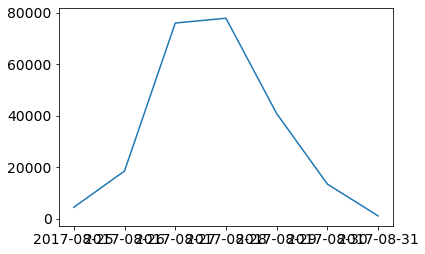

In [124]:
plt.plot(ds.time, rain/86400)

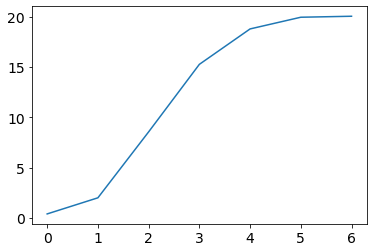

In [108]:
plt.plot(np.cumsum(rain/1000**3))

In [ ]:
# plotting

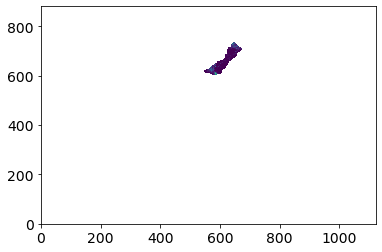

In [96]:
ds0 = ds['observation'].sel(time='2017-8-25')
store = np.zeros_like(ds0).flatten()*np.nan
inds = radar.loc['all', 'irain']
store[inds] = ds0.values.flat[inds]
plt.pcolormesh(store.reshape(ds0.shape))

Rain from Harvey total to compare with GRACE paper

In [24]:
lonsharvey = [-92, -92, -99, -99]
latsharvey = [33, 27, 27, 33]
llharveystereo = stereo.transform_points(pc, np.array(lonsharvey), np.array(latsharvey))
llharveystereo

array([[ 1454183.68042844, -6298761.52855354,        0.        ],
       [ 1640250.57229418, -7104705.78167301,        0.        ],
       [  762178.56455882, -7251644.64240881,        0.        ],
       [  675718.48403844, -6429031.92559652,        0.        ]])

In [25]:
ds

<xarray.Dataset>
Dimensions:                (time: 7, x: 1121, y: 881)
Coordinates:
  * x                      (x) float64 -1.903e+06 -1.898e+06 ... 3.432e+06
  * y                      (y) float64 -3.426e+06 -3.431e+06 ... -7.618e+06
  * time                   (time) datetime64[ns] 2017-08-25 ... 2017-08-31
Data variables:
    crs                    (time) int32 -2147483647 -2147483647 ... -2147483647
    observation            (time, y, x) float64 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
    normal                 (time, y, x) float32 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
    departure_from_normal  (time, y, x) float32 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
    percent_of_normal      (time, y, x) float32 dask.array<shape=(7, 881, 1121), chunksize=(1, 881, 1121)>
Attributes:
    creation_time:  20190314T180953
    data_time:      20170825
    Conventions:    CF-1.6

In [39]:
dsharvey = ds['observation'].sel(x=slice(llharveystereo[:,0].min(), llharveystereo[:,0].max()),
                          y=slice(llharveystereo[:,1].max(), llharveystereo[:,1].min()),
                          time=slice('2017-8-26', '2017-8-30'))
dsharvey.sum(axis=(1,2)).values/1000**3

array([18.58715986, 23.28233423, 25.56039865, 13.6143908 ,  9.78478841])

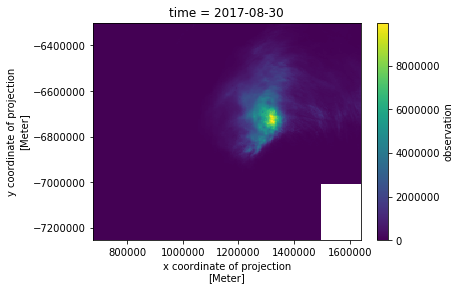

In [45]:
dsharvey.isel(time=4).plot()

In [ ]:
# rain not in galveston watershed
rainout = np.zeros(ds.time.size)
inds = radar.loc['all', 'irain']
for i, time in enumerate(ds.time):
    rainout[i] = ds['observation'].sel(time=time).values.flat[inds].sum()
    
rainout

In [94]:
# these are the indices not in galveston watershed. The rain at these locations, in Texas area, should add up to 90 km^3
inotgalv = list(set(np.arange(X.size)) - set(inds))

# all points outside galveston watershed. But, includes everything outside Texas still
Xnotgalv = X.flat[inotgalv]
Ynotgalv = Y.flat[inotgalv]
# limit to box chosen above
itx = (Xnotgalv > llharveystereo[:,0].min()) & (Xnotgalv < llharveystereo[:,0].max()) \
 & (Ynotgalv > llharveystereo[:,1].min()) & (Ynotgalv < llharveystereo[:,1].max())

# outside galv watershed but inside box
tot = 0
for time in pd.date_range('2017-8-26','2017-8-30',freq='1d'):
    tot += np.nansum(ds['observation'].sel(time=time).values.flat[inotgalv][itx])/1000**3
tot

71.24572233837821